# IA - Function approximation with Genetic Algorithm
## Problem
Astronomers observed a new unknown star. Their first observations make think her surface temperature vary on a regular basis, with periodicities as shown below.
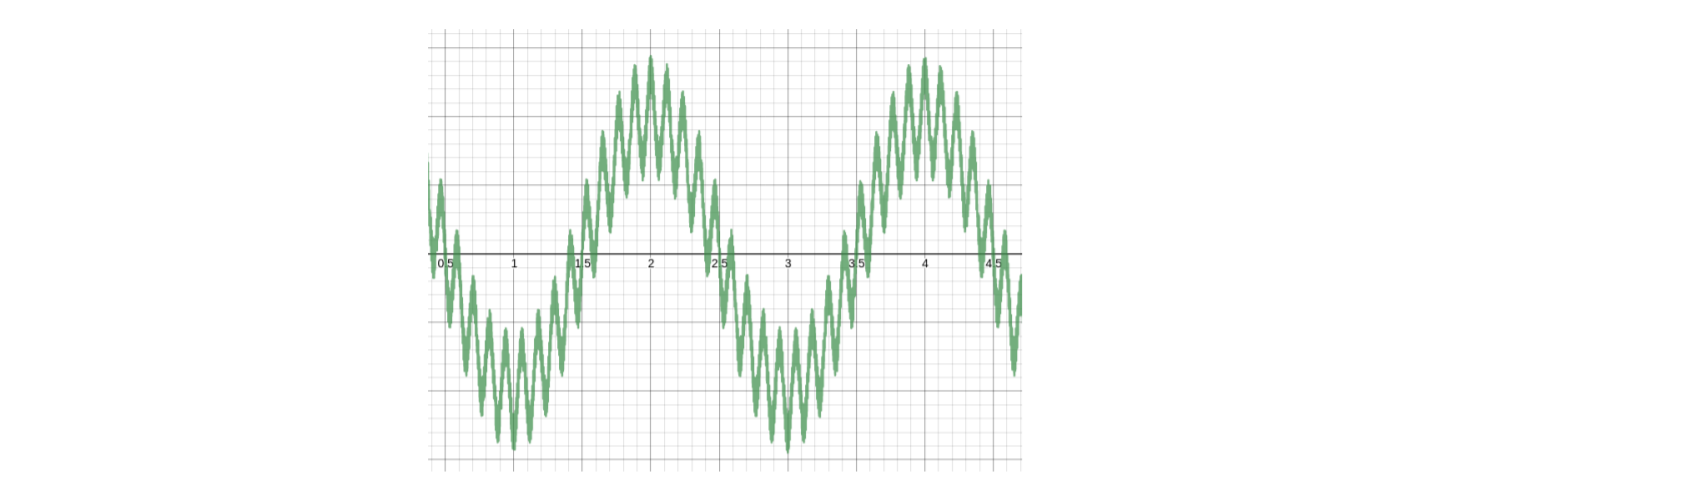
Astronomers assume the star's temperature is following a function namely 'Weierstrass', with nested periodicities, defined as:
* $ t(i) = \sum_{n=0}^{c}{a^n}cos(b^n{\pi}i) $

Having t(i) the temperature of the star at an instant i, with a set of parameters :
* $ A = \{a\,\epsilon\,\mathbb{R}\,|\,a\,\epsilon\,]0,1[\} $
* $ B = \{b\,\epsilon\,\mathbb{N}\,|\,b\,\epsilon\,[[2,20]]\} $
* $ B = \{c\,\epsilon\,\mathbb{N}\,|\,c\,\epsilon\,[[1,20]]\} $

The objective is to find the combination (a,b,c) that could bring closer the Weierstrass function to the observations done at a specific time.

A list of observations is given in 'temperature_sample.csv' file, where each row respresents an observation.
Each observation is composed of the instant, and the observed temperature.

This project asks to create a genetic algorithm from scratch. We don't need to use any library other than random, or matplotlib for observations.

### Let's first define a function to get the data in a dictionnary

In [13]:
import matplotlib.pyplot as plt

In [3]:
def getData(file):
    datas = {}
    with open (file, 'r') as f:
        for line in f.readlines()[1:]:
            data = line.strip().split(';')
            datas[float(data[0])] = float(data[1])
    return datas

In [24]:
datas = getData('temperature_sample.csv')
datas

{1.933: 0.504,
 0.015: 1.209,
 1.879: 1.186,
 1.343: -0.109,
 1.533: -0.338,
 0.062: 0.808,
 0.692: -0.324,
 1.232: -0.879,
 0.366: 0.481,
 0.029: 1.025,
 1.93: 0.691,
 1.082: -0.705,
 1.203: -0.479,
 1.158: -0.997,
 1.113: -1.064,
 0.962: -0.966,
 0.498: 0.119,
 0.907: -0.715,
 0.039: 0.875,
 0.012: 1.191}

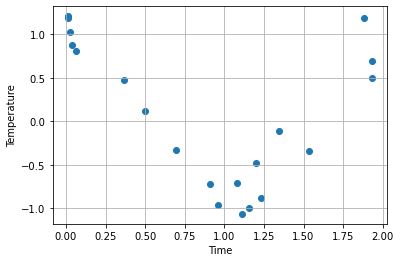

In [28]:
plt.scatter(datas.keys(), datas.values())
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid()
plt.show()

### Now I have to define the Weierstrass function

In [31]:
from numpy import cos, pi

def weierstrass(i,a,b,c):
    """Weierstrass function at instant i, with parameters
    i ∈ R
    a ∈ ]0,1[
    b ∈ [[2, 20]]
    c ∈ [[1, 20]]"""
    w = 0
    for n in range(c + 1):
        w += (a**n)*cos((b**n)*pi*i)
    return w

In [33]:
#Just to check it's working well
weierstrass(2,0.25,5,7)

1.33331298828125

### Then I define my loss function

In [34]:
def loss(params, datas):
    """Calculate the sum of square differences between weierstrass calculated at an instant
    i with paramètres a, b, c, and the true temperature calculated at that instant"""
    score = 0
    a,b,c = params[0], params[1], params[2]
    for i, t in datas.items():
        score += abs(weierstrass(i, a, b, c) - t)
    return score

In [36]:
#Just try with random parameters
loss([0.25,5,7], datas)

5.651171083836809

### I will have to cross over some individuals of my parameters' population

In [37]:
def crossOver(parent1, parent2):
    """Return individual array of parameters inheriting the mean of parameters of his both 'parents'"""
    return [(parent1[0] + parent2[0])/2, (parent1[1] + parent2[1])//2, (parent1[2] + parent2[2])//2]

In [42]:
###Let's test
crossOver([0.2,4,9],[0.6,10,17])

[0.4, 7, 13]

### Second important step in genetic : mutations

In [87]:
from math import log
from random import randint, uniform

def mutation(ind, rate, length):
    """Modifies more or less slightly one of the parameters of the individual, with a mutation rate between 0 and 1"""
    param = randint(0,2)
    power = 16*log(10, length)
    add, maximum = (uniform(-0.5*(rate**power),0.5*(rate**power)), 1) if param == 0 \
        else (randint(int(-9*rate) - 1, int(9*rate) + 1), 20)
    ind[param] += add if ind[param] + add <= maximum and ind[param] + add >= 1 else -add
 

Let's describe this function.
First we define a random value namely 'param', corresponding to the param we will mutate.
* 0 -> a
* 1 -> b
* 2 -> c
First we'll observe the case the algorithm mutates the value of b or c, so 'param' != 0.

So if param != 0, we define a param named 'add', which is a random integer between -9*rate and +9*rate. It means greater will be the rate, greater will be the difference between 'add' and 0. We also define 'maximum', which will be equals to 20, since the subject precised b and c between 1 or 2, and 20.

Then the 'add' value will be added to the b or c parameter of the individual. If that sum get higher than 20, or smaller than 1, we just add the opposite value of 'add', since 'add' cannot be smaller than -9 or higher than +9.

In the case 'param' = 0, things are a bit different, because a is a real number. We don't have 20 diferent possibilities as for b or c, but infinite possible values for a. In fact, since we are using python, we have a finit number of posibilities. Python cannot show more than 16 digits. So in fact, we have $ 10^{16} $ possibilities for a, which is huge.

But how can we make a very small mutation for a, close to $ 10^{-16} $ when the individual have a very good score, and a big mutation around 0.5 for individuals with bad score, knowing the 'rate' will give us the information of the position of the individual in the population (if rate is close to 0, it means the individual have a good score). We cannot just take a random number between -0.5 and +0.5, and multiply by the rate. At most, rate will be 1/n, with n the length of the population, so, even if we have a random number between -0.1 and 0.1, we will never increase or decrease a of only $ 10^{-16} $.

This is why we define a 'power' variable, and we are using log. To get a rate closer to $ 10^{-16} $, we can put rate to the power of k, since rate is between 0 and 1, closer rate will be to 0, closer rate power k will be close to $ 10^{-16} $. But we cannot take any k. To determine that power, I made that math calcul :
* $ (\frac{1}{n})^k = 10^{-16} <=> k.log(\frac{1}{n}) = -16.log(10) <=> k = -16.\frac{log(10)}{log(\frac{1}{n})} = 16.\frac{log(10)}{log(n)} <=> k = 16.log_{n}(10) $

That's the most precise way to mutate a a lot if the individual doesn't have a great score, and a very few if it has.

In [62]:
#Test with random individual
ind = [0.4,13,7]
for i in range(3):
    mutation(ind, 0.7, 20)
    print(ind)

[0.4, 13, 14]
[0.4, 13, 7]
[0.4, 13, 1]


### Now I can define the treatment of the population on each generation

In [85]:
def treatment(population, datas):
    """Makes cross-overs, mutations, and sort according to the result of the loss, 
    the individuals of the population on a generation"""
    _sqrt = int(len(population) ** (1/2)) + 1
    k=1
    
    #CrossOver between every individuals of the population
    for i in range(_sqrt):
        for j in range(i + 1, _sqrt):
                population[-k] = crossOver(population[i], population[j])
                k+=1
    #First sort according to loss score
    population.sort(key = lambda i : loss(i, datas))
    
    #Mutation of one parameter of every individuals except the best one of the population
    for i in range(1, len(population)):
        #The 'rate' is defined as i/n, where n is the length of the population.
        #If i-th individual is well classed, rate will be close to 0.
        mutation(population[i], i / len(population), len(population))
    population.sort(key = lambda i : loss(i, datas))

### And a final method to run the program we created

In [131]:
from time import time
def run(datas, lenPop = 100, nbGen = 150, minLoss = 0):
    """Main function, initializing a population of 'lenPop' individuals arrays of parameters,
    and makes operations during 'nbGen' generations, before displaying the best array of parameters
    of the population according to the 'datas', and save the parameters"""
    gen = 0
    
    #First I initialize a population of lists of random parameters, and I sort them according
    #to the loss function
    population =[[uniform(0,1), randint(1,20), randint(1,20)] for i in range(lenPop)]
    population.sort(key = lambda i : loss(i, datas))
    
    bestSol = {}
        
    print('...Processing...\n')
    begin = time()
    while gen < nbGen and loss(population[0], datas) > minLoss:
        bestSol[gen] = loss(population[0], datas)
        #print(gen)
        #print(population[0], loss(population[0], datas))
        treatment(population, datas)
        gen += 1
        
    print(f'Result found in {(time() - begin):.2f} seconds')
    sol = population[0]
    print(sol, loss(sol, datas))
    print(gen, 'generations')
    with open('solution.txt','w') as f:
        f.write(';'.join([str(i) for i in sol]))
    fig, axes = plt.subplots(1,2, figsize=(20,5))
    axes[0].plot(bestSol.keys(), bestSol.values())
    axes[0].set_xlabel('Generation')
    axes[0].set_ylabel('Loss')
    axes[0].grid()
    axes[1].plot(list(bestSol.keys())[len(bestSol)//2:], list(bestSol.values())[len(bestSol)//2:])
    axes[1].set_xlabel('Generation')
    axes[1].set_ylabel('Loss')
    axes[1].grid()
    plt.show()

### Before trying our program with our datas, let's try with our own dictionnary created with parameters we chose

In [73]:
def createDataTest(a,b,c):
    """Returns a dictionnary where each key is an instant i of the datas, and each value
    is a theorical temperature t calculated at instant i using weierstrass function"""
    datas = {}
    for k in range(20):
        i = round(uniform(0,2), 3)
        datas[i] = weierstrass(i, a, b, c)
    return datas

0.28895150887417864 9 13


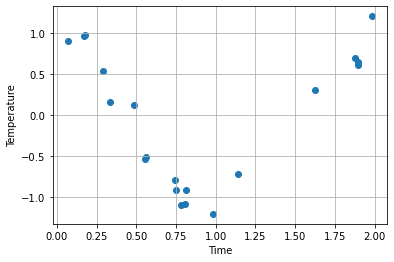

In [133]:
a,b,c = uniform(0,1), randint(2,20), randint(1,20)
print(a,b,c)
datas = createDataTest(a,b,c)

plt.scatter(datas.keys(), datas.values())
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid()
plt.show()

...Processing...

Result found in 7.85 seconds
[0.28895150887417864, 9, 13] 0.0
39 generations


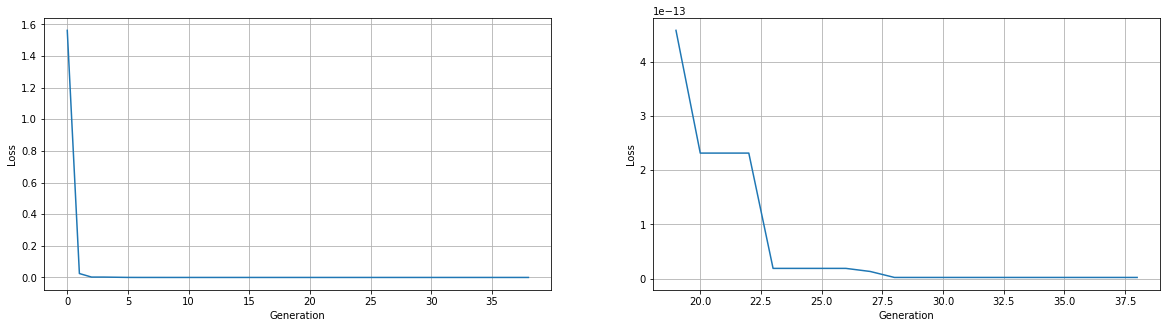

In [135]:
run(datas)

The algorithm found the exact solution in around 5 seconds !

Now we can do it with our datas in 'temperature_sample.csv'. As there are some noise on the datas, it will not be possible to find a solutions with a loss function equal to 0. But our program will find the most close solution.

...Processing...

Result found in 3.89 seconds
[0.35288545359095314, 15, 2] 0.7351051480069459
150 generations


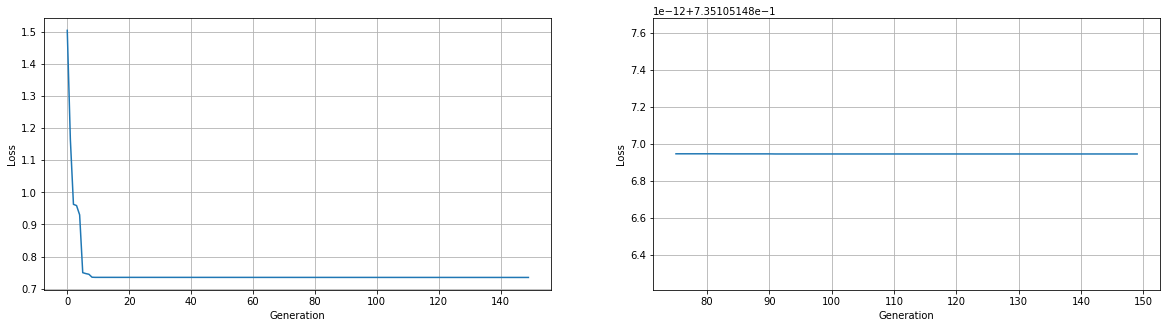

In [136]:
datas = getData('temperature_sample.csv')
run(datas)